# <b><span style='color:#38c9ff;font-size:150%'>Sensorización y Machine Learning</span><br>Por: Ruben Durango </b>
---
## 📃| **Introducción**
Pendiente

## 🔢| **Objetivos**


---

## 📑 | Tabla de Contenido|

- [**1. Descripción de los campos**](#datos)
- [**2. Análisis Exploratorio de los Datos**](#eda)
    - [**2.1 Los Sujetos**](#eda)
    - [**2.2 Los Sensores**](#sensores)
    - [**2.3 Las Series de Tiempo**](#time)

**🧩Inicializacion del Notebook**

In [54]:
# Inicializacion del Notebook

import numpy as np # Libreria para trabajar con matrices
import pandas as pd # Libreria para trabajar con dataframes
import scipy.stats # Libreria para trabajar con estadisticas

import matplotlib.pyplot as plt # Libreria para trabajar con graficas
import seaborn as sns
from matplotlib.ticker import MaxNLocator # Libreria para trabajar con graficas
from cycler import cycler # Libreria para trabajar con graficas
from IPython.display import display # Libreria para presentar informacion


# Librerias para modelado
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

# Valores base para matplotlib
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=18,
    titlepad=16,
    facecolor = '#f0f3f4',
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

plt.style.use('fivethirtyeight') # Estilo de los Graficos
colores = ['#38C9FF','#00DBF6','#00EADB','#67F5B4','#B2FA8C','#F9F871']

from warnings import simplefilter # Libreria para evitar warnings
simplefilter("ignore")

<a class="anchor" id="datos"></a> 

# <div style="color:white;display:fill;border-radius:5px;background-color:#38c9ff;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:#FFFFFF;overflow:hidden;margin:0;font-size:110%"><b>1 | Descripción de los Datos</b></p></div>

## <b><span style='color:#38c9ff'>1.1</span> | Objetivo Principal</b>
pendiente

## <b><span style='color:#38c9ff'>1.2</span> | Descripción de los campos</b>

1. **train.csv** - El conjunto de entrenamiento, que comprende ~26 000 grabaciones de 60 segundos de trece sensores biológicos para casi mil participantes experimentales
    - `sequence` - Una identificación única para cada secuencia
    - `subject` - Una identificación única para el sujeto en el experimento
    - `step` - Paso de tiempo de la grabación, en intervalos de un segundo
    - `sensor_00 - sensor_12` - El valor de cada uno de los trece sensores en ese paso de tiempo
2. **train_labels.csv** - La etiqueta de clase para cada secuencia.
    - `sequence` - Una identificación única para cada secuencia.
    - `state` - El estado asociado a cada secuencia. **Este es el objetivo que se está tratando de predecir**.
3. **test.csv** - El conjunto de prueba. Para cada una de las ~12 000 secuencias, se debe predecir un valor para el estado de esa secuencia.

In [2]:
# Analizando los cada Dataset
train = pd.read_csv('data/train.csv')
train_labels = pd.read_csv('data/train_labels.csv')
test = pd.read_csv('data/test.csv')

print("train Dataset -------------------------------------------------")
print("Existen {:,} Observaciones y {} Columnas en el `train` dataset.".format(train.shape[0], train.shape[1]))
print("Existen {} Valores faltantes en el `train` dataset.".format(train.isna().sum().sum()))
print("Existen {} Valores duplicados en el `train` dataset.".format(train.duplicated().sum()))
print("")
print("train_labels Dataset ------------------------------------------------")
print("Existen  {:,} Observaciones y {} Columnas en el `train_labels` dataset.".format(train_labels.shape[0], train_labels.shape[1]))
print("Existen {} Valores faltantes en el `train_labels` dataset.".format(train_labels.isna().sum().sum()))
print("Existen {} Valores duplicados en el `train_labels` dataset.".format(train_labels.duplicated().sum()))
print("")
print("test Dataset --------------------------------------------------")
print("Existen {:,} Observaciones y {} Columnas en el `test` dataset.".format(train_labels.shape[0], train_labels.shape[1]))
print("Existen {} Valores faltantes en el `test` dataset.".format(train_labels.isna().sum().sum()))
print("Existen {} Valores duplicados en el `test` dataset.".format(train_labels.duplicated().sum()))

train Dataset -------------------------------------------------
Existen 1,558,080 Observaciones y 16 Columnas en el `train` dataset.
Existen 0 Valores faltantes en el `train` dataset.
Existen 0 Valores duplicados en el `train` dataset.

train_labels Dataset ------------------------------------------------
Existen  25,968 Observaciones y 2 Columnas en el `train_labels` dataset.
Existen 0 Valores faltantes en el `train_labels` dataset.
Existen 0 Valores duplicados en el `train_labels` dataset.

test Dataset --------------------------------------------------
Existen 25,968 Observaciones y 2 Columnas en el `test` dataset.
Existen 0 Valores faltantes en el `test` dataset.
Existen 0 Valores duplicados en el `test` dataset.


<div class="alert alert-block alert-info" style="color:#03162D;border-color:#38c9ff;border-radius:2px;background-color:#d2f2ff; font-size:12px; font-family:verdana; line-height: 1.7em;">
    <b><span style='color:#38c9ff'>  Observaciones</span></b> | Sobre los Datasets `train` y `train_labels`

- Hay **25968 Secuencias** en el dataset `labels`, y en el `train_labels` hay 60 registros (steps) para cada secuencia, por lo que hay **1558080 registros**

- Cada secuencia tiene **13 valores** (`sensor_00 - sensor_12`) y **60 steps**, asi que hay **780 variables** en este ejercicio de clasificación binaria

In [3]:
# Estadisticos Resumen
display(train.describe(include=['float','int']).T.round(3).style.format('{:,.2f}')
        .bar(color='#38c9ff', axis=0, vmin=0)
        .set_caption("Estadísticos Resumen para el dataset `train`"))

,count,mean,std,min,25%,50%,75%,max
sequence,"1,558,080.00","12,983.50","7,496.32",0.00,"6,491.75","12,983.50","19,475.25","25,967.00"
subject,"1,558,080.00",331.63,195.83,0.00,161.75,335.00,501.00,671.00
step,"1,558,080.00",29.50,17.32,0.00,14.75,29.50,44.25,59.00
sensor_00,"1,558,080.00",0.00,2.66,-375.06,-0.50,-0.00,0.48,335.82
sensor_01,"1,558,080.00",-0.00,4.40,-434.60,-0.48,0.00,0.49,449.59
sensor_02,"1,558,080.00",-0.22,2.30,-31.66,-0.65,0.00,0.33,1.67
sensor_03,"1,558,080.00",-0.00,3.93,-408.38,-0.49,0.00,0.49,436.65
sensor_04,"1,558,080.00",-0.00,1.68,-23.63,-0.47,-0.00,0.47,24.87
sensor_05,"1,558,080.00",-0.00,1.59,-74.98,-0.48,0.00,0.51,77.92
sensor_06,"1,558,080.00",-0.00,3.35,-470.50,-0.49,0.00,0.49,442.50


In [4]:
# Estadisticos Resumen
display(train_labels.describe(include=['float','int']).T.round(3).style.format('{:,.2f}')
        .bar(color='#38c9ff', axis=0, vmin=0)
        .set_caption("Estadísticos Resumen para el dataset `train_labels`"))

,count,mean,std,min,25%,50%,75%,max
sequence,"25,968.00","12,983.50","7,496.46",0.00,"6,491.75","12,983.50","19,475.25","25,967.00"
state,"25,968.00",0.50,0.50,0.00,0.00,1.00,1.00,1.00


<a class="anchor" id="eda"></a> 

# <div style="color:white;display:fill;border-radius:5px;background-color:#38c9ff;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:#FFFFFF;overflow:hidden;margin:0;font-size:110%"><b>2 |</b>  Análisis exploratorio de datos</p></div>

En esta sección realizaremos un análisis individual para cada uno de los elementos de este ejercicio, estos son:
-	Los sujetos de estudio
-	Los sensores
-	Las lecturas de los sensores

Y finalmente realizaremos un análisis de **componentes principales o (PCA)** para entender a una mayor profundidad nuestros datos. 


## <b><span style='color:#38c9ff'>2.1</span> | Los Sujetos</b>

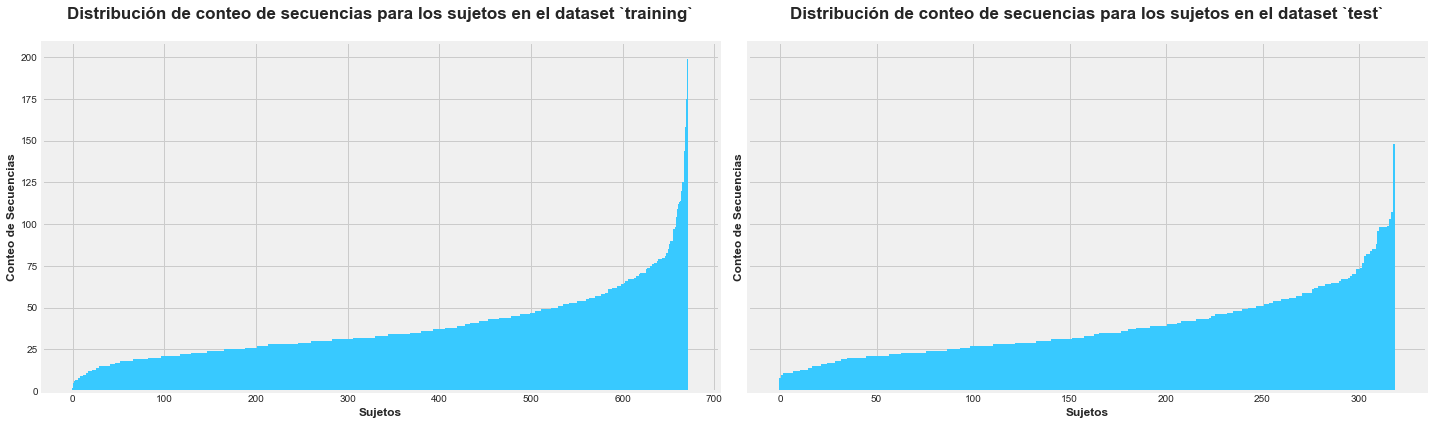

In [3]:
plt.subplots(1, 2, sharey=True, figsize=(20, 6))

def plot_sequence_count_distribution(df, title):
    temp = df.subject.value_counts().sort_values() // 60
    plt.bar(range(len(temp)), temp, width=1, color = '#38c9ff')
    plt.xlabel('Sujetos')
    plt.ylabel('Conteo de Secuencias') 
    plt.title(f'Distribución de conteo de secuencias para los sujetos en el dataset `{title}`', 
              y=1.02, fontsize=17)

plt.subplot(1, 2, 1)
plot_sequence_count_distribution(train, 'training')
plt.subplot(1, 2, 2)
plot_sequence_count_distribution(test, 'test')
plt.show()

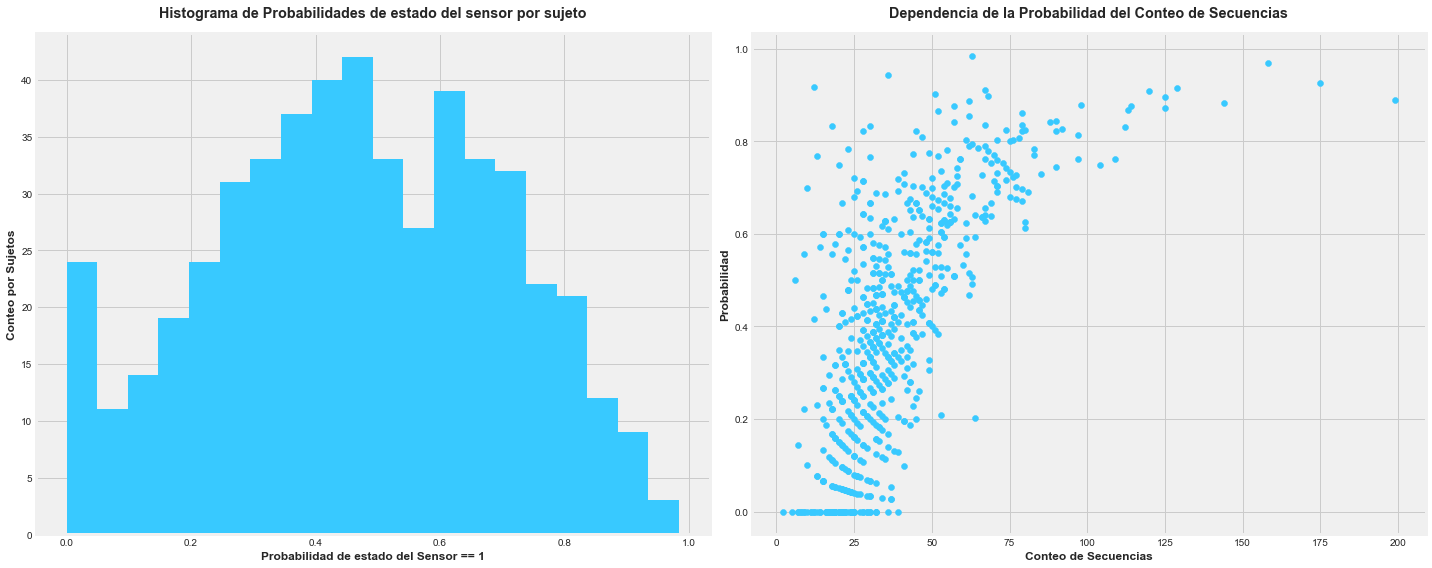

Sujetos que siempre están en el estado 0: 59 Sujetos


In [4]:
temp = train.groupby('sequence').subject.min() # dataframe with one row per sequence
temp = train_labels.merge(temp, on='sequence') # adding the labels
temp = temp.groupby('subject').agg({'state': 'mean', 'sequence': 'count'}).rename(columns={'state': 'probability', 'sequence': 'sequence_count'})
temp1 = temp[temp.sequence_count >= 25].probability.rename('Probability of state==1')

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.hist(temp1, bins=20,color = '#38c9ff')
plt.ylabel('Conteo por Sujetos')
plt.xlabel('Probabilidad de estado del Sensor == 1')
plt.title('Histograma de Probabilidades de estado del sensor por sujeto')

plt.subplot(1, 2, 2)
plt.scatter(temp.sequence_count, temp.probability,color = '#38c9ff')
plt.xlabel('Conteo de Secuencias')
plt.ylabel('Probabilidad')
plt.title('Dependencia de la Probabilidad del Conteo de Secuencias')

plt.show()
print('Sujetos que siempre están en el estado 0:', (temp.probability == 0).sum(),'Sujetos')

## <b><span style='color:#38c9ff'>2.2</span> | Los Sensores</b>

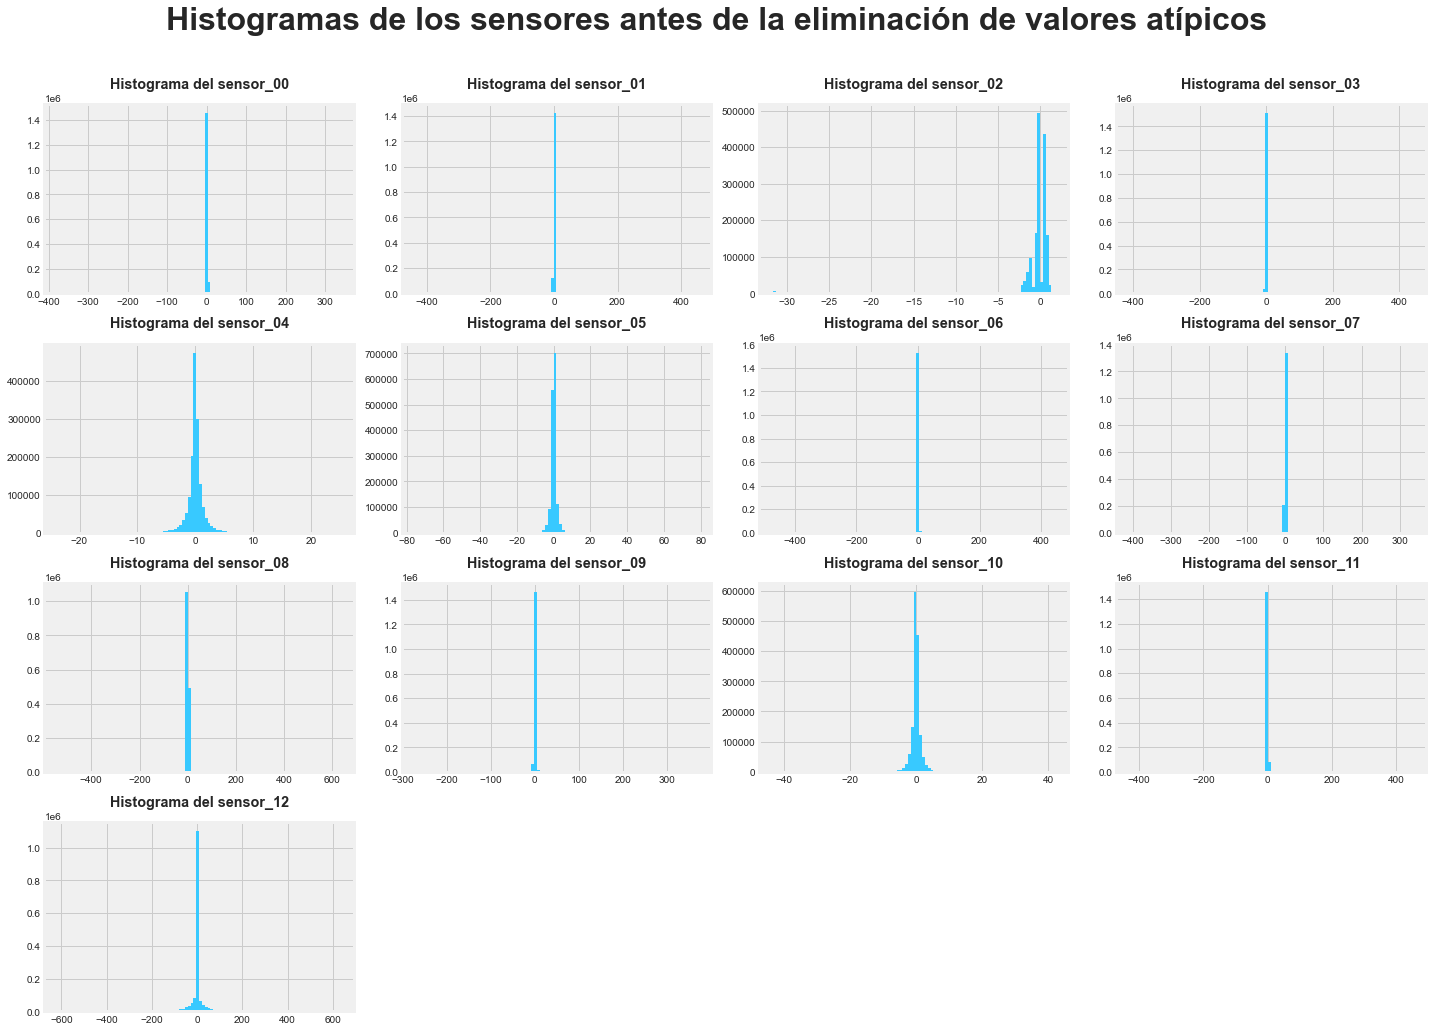

In [5]:
figure = plt.figure(figsize=(20, 14))
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plt.subplot(4, 4, sensor+1)
    plt.hist(train[sensor_name], bins=100, color = '#38c9ff')
    plt.title(f"Histograma del {sensor_name}")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Histogramas de los sensores antes de la eliminación de valores atípicos', 
             y=1.02, fontsize=32, fontweight='bold')
plt.show()

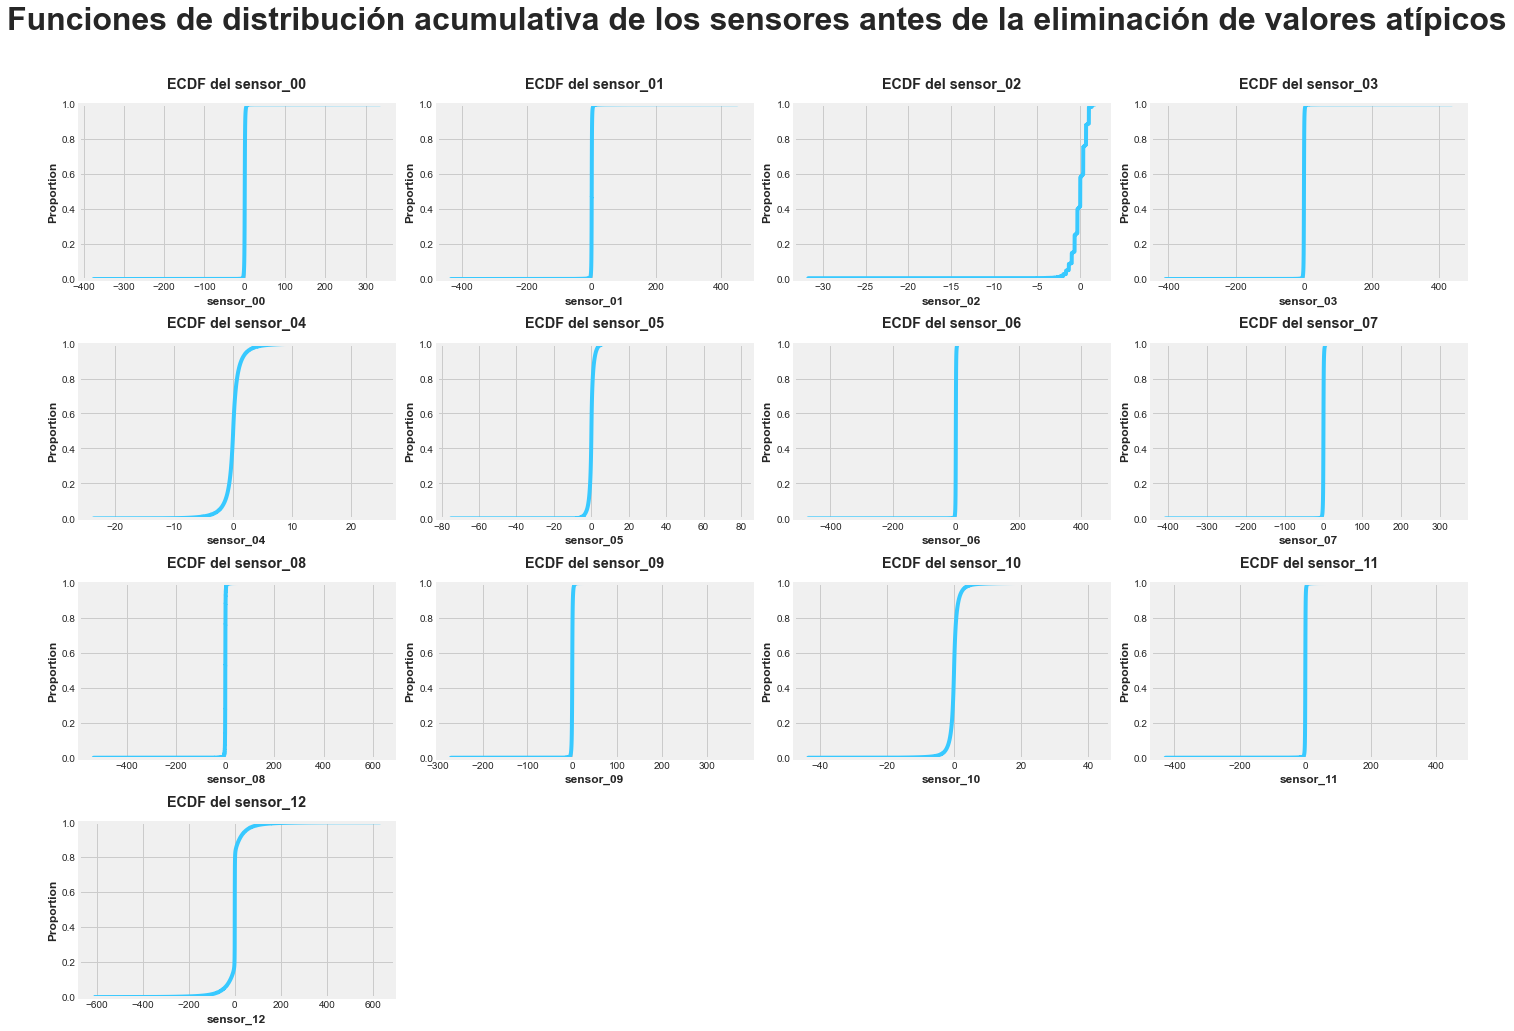

In [6]:
figure = plt.figure(figsize=(20, 14))
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plt.subplot(4, 4, sensor+1)
    sns.ecdfplot(train[sensor_name], color='#38c9ff')
    plt.title(f"ECDF del {sensor_name}")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Funciones de distribución acumulativa de los sensores antes de la eliminación de valores atípicos', 
             y=1.02, fontsize=32, fontweight='bold')
plt.show()

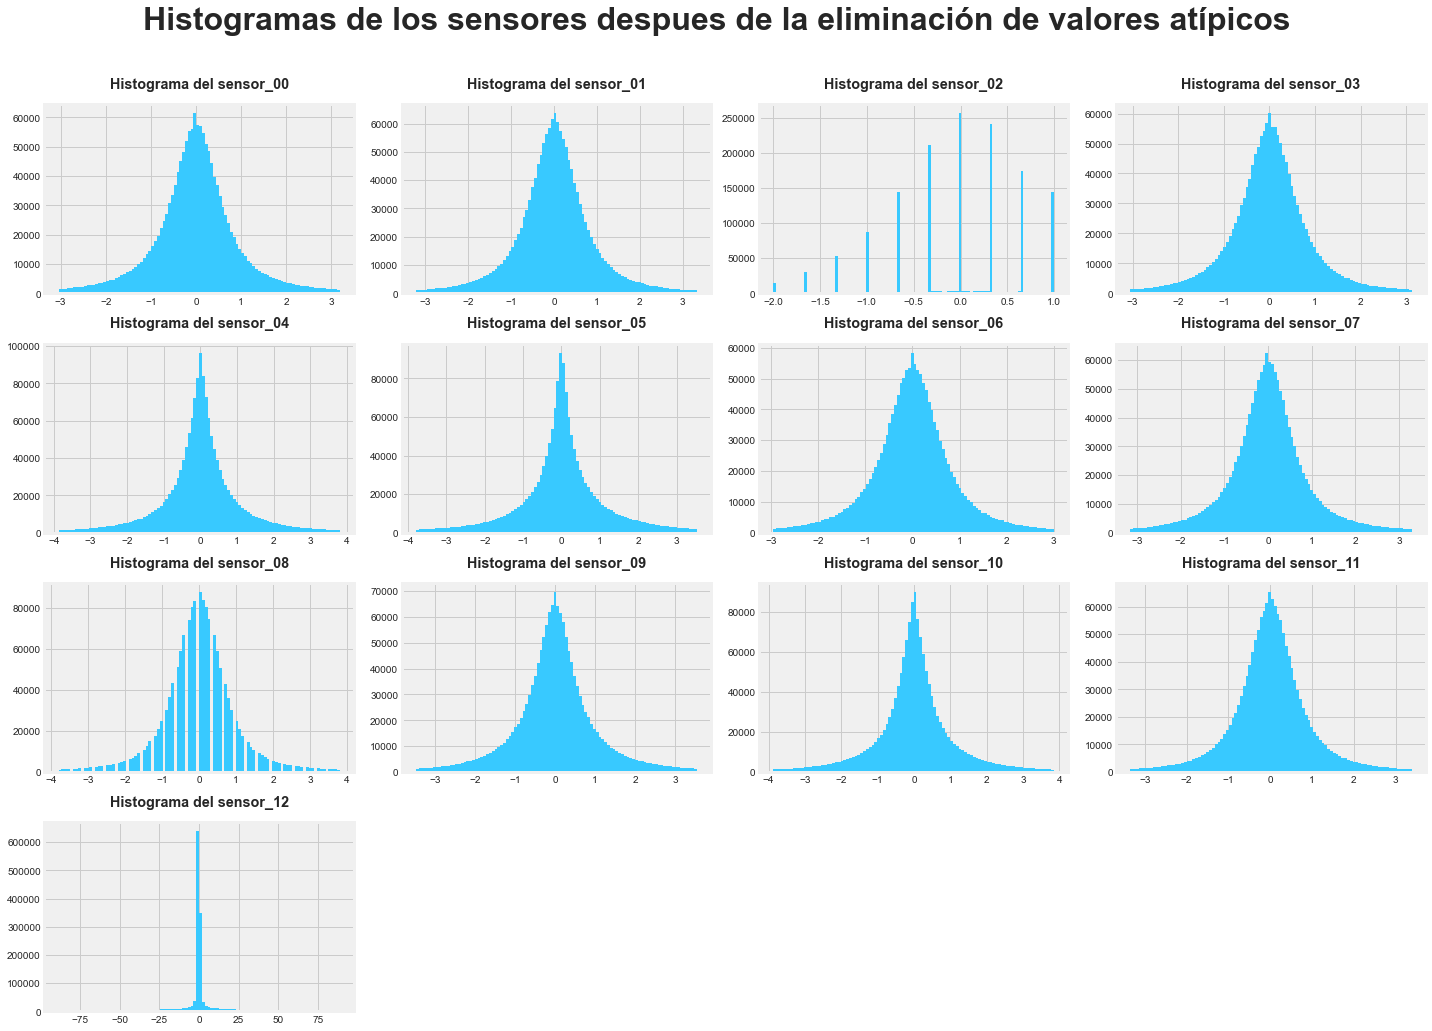

In [7]:
figure = plt.figure(figsize=(20, 14))
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plt.subplot(4, 4, sensor+1)
    plt.hist(train[sensor_name], bins=100, color = '#38c9ff',
             range=(train[sensor_name].quantile(0.02),
                    train[sensor_name].quantile(0.98)))
    plt.title(f"Histograma del {sensor_name}")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Histogramas de los sensores despues de la eliminación de valores atípicos', 
             y=1.02, fontsize=32, fontweight='bold')
plt.show()

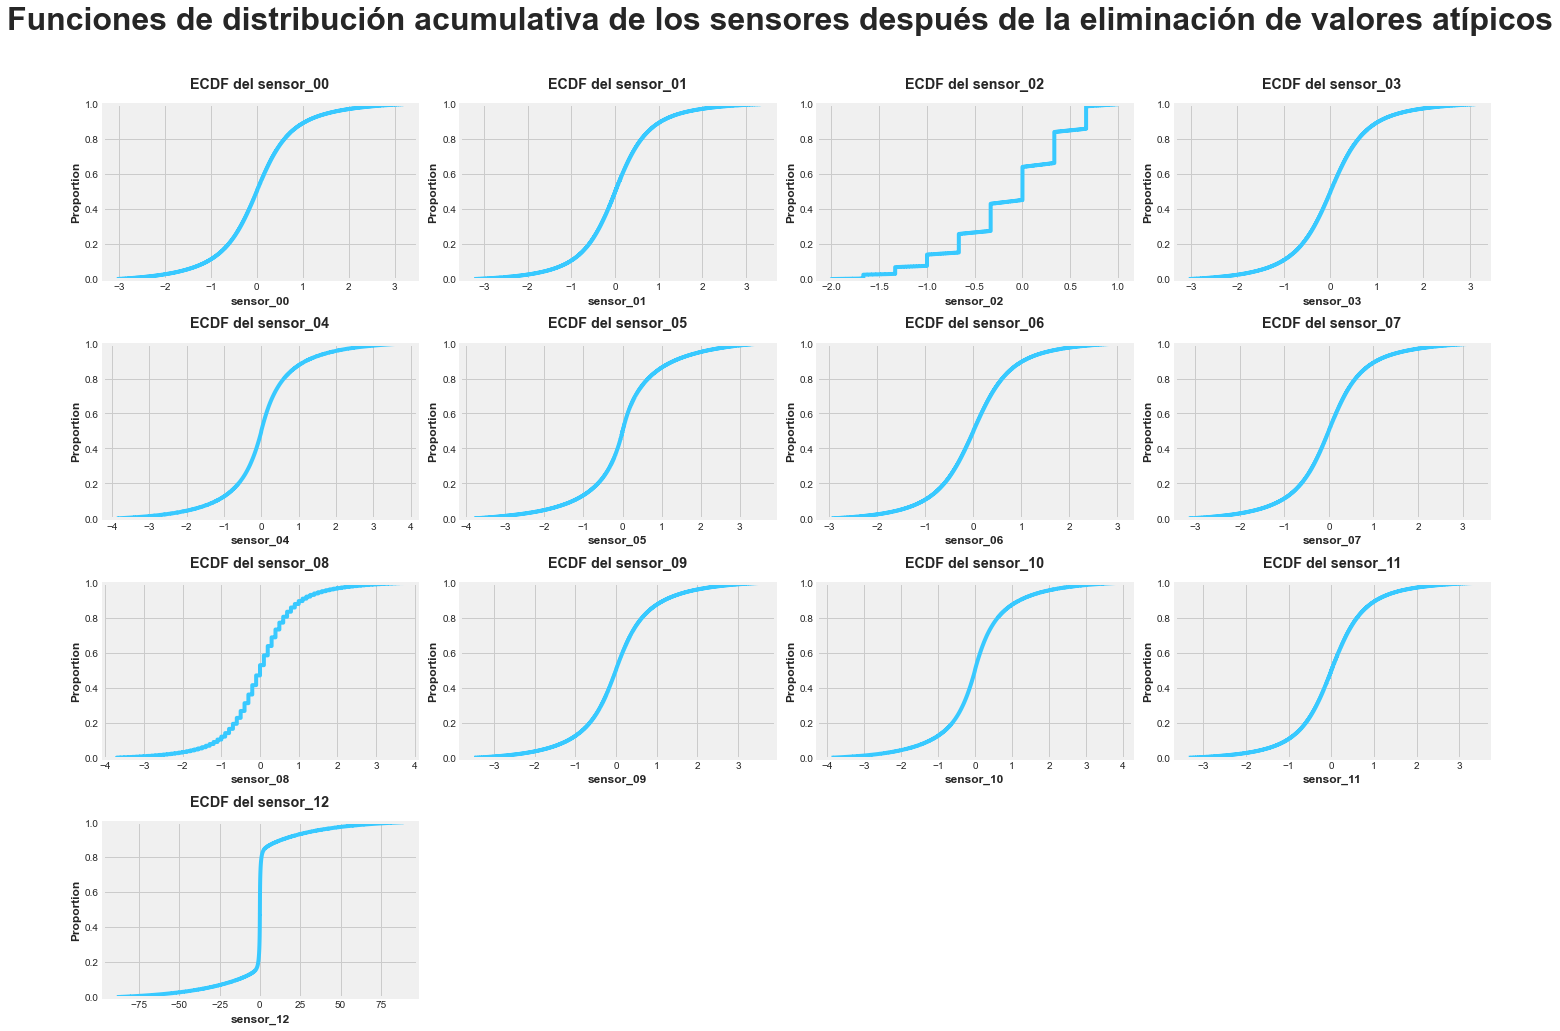

In [8]:
figure = plt.figure(figsize=(20, 14))
for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    plt.subplot(4, 4, sensor+1)
    sns.ecdfplot(train[sensor_name][(train[sensor_name] < train[sensor_name].quantile(0.98))&
                                    (train[sensor_name] > train[sensor_name].quantile(0.02))], color='#38c9ff')
    plt.title(f"ECDF del {sensor_name}")
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Funciones de distribución acumulativa de los sensores después de la eliminación de valores atípicos', 
             y=1.02, fontsize=32, fontweight='bold')
plt.show()

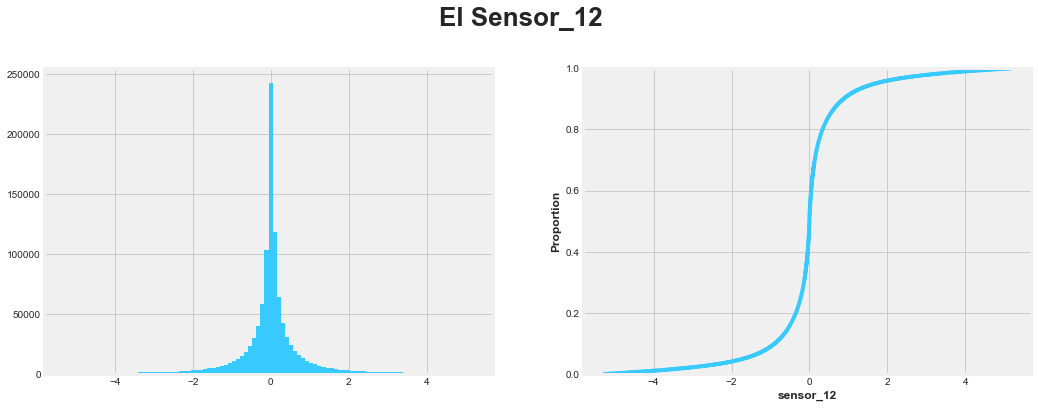

In [30]:
sensor_name = 'sensor_12'
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16, 6))
plt.suptitle(f"El Sensor_12", fontsize=26, fontweight='bold')
axs[0].hist(train[sensor_name], bins=100, color='#38c9ff',
         range=(train[sensor_name].quantile(0.15),
                train[sensor_name].quantile(0.85)))

sns.ecdfplot(train[sensor_name][(train[sensor_name] < train[sensor_name].quantile(0.85))&
                                    (train[sensor_name] > train[sensor_name].quantile(0.15))], color='#38c9ff', ax=axs[1])

plt.show()

## <b><span style='color:#38c9ff'>2.3</span> | Las lecturas de los sensores</b>

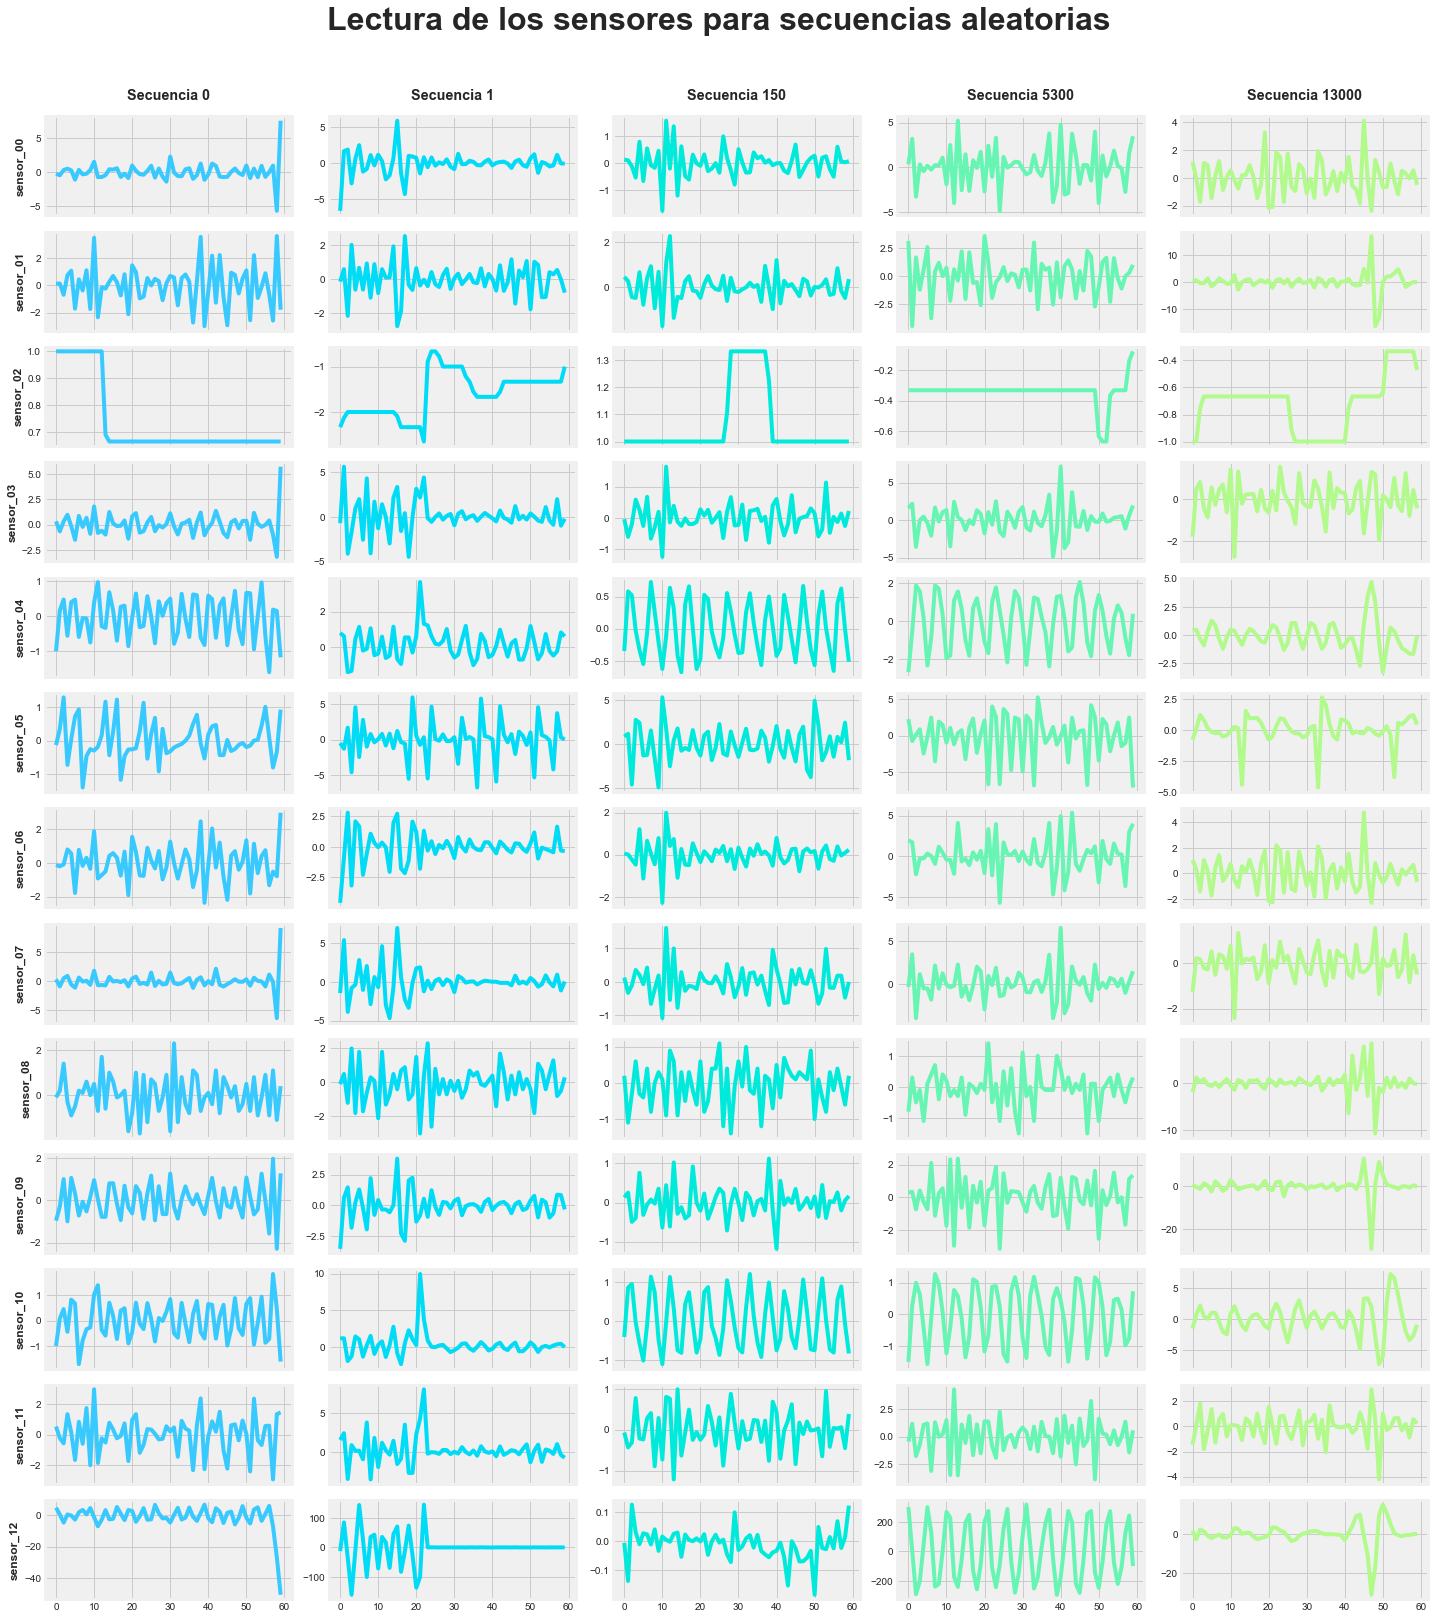

In [35]:
sequences = [0, 1, 150, 5300, 13000]
figure, axes = plt.subplots(13, len(sequences), sharex=True, figsize=(20, 22))
for i, sequence in enumerate(sequences):
    for sensor in range(13):
        sensor_name = f"sensor_{sensor:02d}"
        plt.subplot(13, len(sequences), sensor * len(sequences) + i + 1)
        plt.plot(range(60), train[train.sequence == sequence][sensor_name],
                color=colores[i % 10])
        if sensor == 0: plt.title(f"Secuencia {sequence}")
        if sequence == sequences[0]: plt.ylabel(sensor_name)
figure.tight_layout(w_pad=0.1)
plt.suptitle('Lectura de los sensores para secuencias aleatorias'
             ,y=1.02, fontsize=32, fontweight='bold')
plt.show()

In [32]:
# Para cada Sensor: Cuenta las secuencias donde el sensor mide un valor constante
def stuck_at_constant(seq):
    return seq.min() == seq.max()

for sensor in range(13):
    sensor_name = f"sensor_{sensor:02d}"
    stuck_sequences = train.groupby('sequence')[sensor_name].apply(stuck_at_constant)
    print(f"{sensor_name}: {stuck_sequences.sum():4d}   {train_labels[stuck_sequences].state.mean()}")

sensor_00:   44   0.0
sensor_01:   44   0.0
sensor_02: 1280   0.04609375
sensor_03:   44   0.0
sensor_04:   25   0.0
sensor_05:    0   nan
sensor_06:   44   0.0
sensor_07:   44   0.0
sensor_08:   44   0.0
sensor_09:   44   0.0
sensor_10:    0   nan
sensor_11:   44   0.0
sensor_12:   19   0.0


Pivotando los Datos

In [36]:
train_pivoted = train.pivot(index=['sequence', 'subject'], columns='step', values=[col for col in train.columns if 'sensor_' in col])
train_pivoted

sensor_00                                                    \
step                    0         1         2         3         4         5    
sequence subject                                                               
0        47      -0.196291 -0.447450  0.326893  0.523184  0.272025 -1.073416   
1        66      -6.657651  1.633694  1.863215 -2.846213  0.593509  2.469861   
2        66      -1.741886  3.402628 -0.632148  0.208655 -0.800618 -2.274343   
3        542      0.264297 -1.808346  0.078825  1.037094 -0.189335 -1.302937   
4        437      0.567233 -0.823802  1.476816 -1.710201 -0.408810  0.556414   
...                    ...       ...       ...       ...       ...       ...   
25963    558     -1.441267  2.359351 -0.881762  1.299073 -0.862442 -1.428130   
25964    297      0.996909  0.415765  1.874034 -5.220247  2.927357 -0.311437   
25965    129     -0.097372 -0.860896  0.928903  0.750386  1.346986 -3.422720   
25966    170     -0.357032 -1.603555 -0.296754  0.273570  0.462133  0.244977   
25967    327     -0.313756  0.392581 -0.554096  0.070325 -0.258114  0.095054   

                                                          ...  sensor_12  \
step                    6         7         8         9   ...         50   
sequence subject                                          ...              
0        47       0.350850 -0.304482 -0.216383  0.303709  ...  -1.670077   
1        66      -1.202473 -0.829212  1.091190 -0.334621  ...  -0.338022   
2        66       2.009274 -0.563369 -0.050232  0.800618  ...  -0.172634   
3        542      1.078825  2.257342 -2.283617 -2.759660  ...   0.145354   
4        437      0.853168 -0.406491 -0.009274 -0.021638  ...   0.001705   
...                    ...       ...       ...       ...  ...        ...   
25963    558      0.125193  2.119784  0.208655  1.847759  ...   0.049020   
25964    297      0.496909  0.372488 -0.341577 -0.565688  ...  36.889173   
25965    129      0.983771  2.818393 -1.460587 -1.988408  ...   2.394714   
25966    170     -0.341577 -0.229521  0.877125 -1.197063  ...  14.010656   
25967    327      0.387172 -0.824575  0.471406 -0.037094  ...   0.909207   

                                                                         \
step                     51         52         53         54         55   
sequence subject                                                          
0        47       -5.306479   3.621057   4.965047  -3.615090   0.791134   
1        66        0.234868   0.030691   0.037511  -0.120205   0.056692   
2        66        0.091645  -0.028986  -0.202472   0.332481  -0.013214   
3        542      -0.045610  -0.098039  -0.049446   0.055840  -0.022165   
4        437      -0.050725  -0.025149   0.106138  -0.098465  -0.040068   
...                     ...        ...        ...        ...        ...   
25963    558      -0.089940   0.059250  -0.013640  -0.083973   0.026002   
25964    297      21.105286  -4.421142  16.871697  -4.326939 -13.625320   
25965    129      -0.677323   1.435209  -0.645780  -0.449275   0.271952   
25966    170      48.826939  25.958227  -7.077153 -12.375533   9.170077   
25967    327      -0.830776  -1.007246   1.064365   0.639812  -0.914749   

                                                             
step                    56         57         58         59  
sequence subject                                             
0        47       5.887042  -7.211424 -26.738704 -50.658994  
1        66       0.062234  -0.013640   0.098039  -0.115090  
2        66       0.245524  -0.091219  -0.306905   0.046036  
3        542      0.054135  -0.185422   0.311168  -0.166240  
4        437      0.135976   0.121910  -0.059676  -0.087809  
...                    ...        ...        ...        ...  
25963    558      0.036232  -0.042199   0.028986  -0.015772  
25964    297      9.957374 -13.389173 -17.123615   9.219523  
25965    129     -0.262575   0.713129  -1.378517   1.802217  
25966    170      6.789855 -15.28729

In [37]:
temp = train_pivoted.sort_values(by=list(train_pivoted.columns))
duplicates_first = temp.duplicated(keep='first')
duplicates_last = temp.duplicated(keep='last')
temp['duplicates_first'] = duplicates_first
temp['duplicates_last'] = duplicates_last
duplicates = temp[duplicates_first | duplicates_last]
display(duplicates)

sensor_00                                                    \
step                     0         1         2         3         4         5   
sequence subject                                                               
5882     573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
16294    573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
346      573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
1772     573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
14349    234      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
21524    234      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
3335     359      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
9324     359      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
16829    359      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
25576    359      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
1957     401      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
4512     401      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
6428     234      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
12958    234      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
1586     48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
10633    48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
1428     48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
25450    48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
2817     48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
11926    48       0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
36       573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   
11560    573      0.000773  0.000773  0.000773  0.000773  0.000773  0.000773   

                                                          ... sensor_12  \
step                     6         7         8         9  ...        52   
sequence subject                                          ...             
5882     573      0.000773  0.000773  0.000773  0.000773  ...  0.547315   
16294    573      0.000773  0.000773  0.000773  0.000773  ...  0.547315   
346      573      0.000773  0.000773  0.000773  0.000773  ...  0.561381   
1772     573      0.000773  0.000773  0.000773  0.000773  ...  0.561381   
14349    234      0.000773  0.000773  0.000773  0.000773  ...  0.031969   
21524    234      0.000773  0.000773  0.000773  0.000773  ...  0.031969   
3335     359      0.000773  0.000773  0.000773  0.000773  ...  0.046462   
9324     359      0.000773  0.000773  0.000773  0.000773  ...  0.046462   
16829    359      0.000773  0.000773  0.000773  0.000773  ...  0.046462   
25576    359      0.000773  0.000773  0.000773  0.000773  ...  0.046462   
1957     401      0.000773  0.000773  0.000773  0.000773  ... -0.616795   
4512     401      0.000773  0.000773  0.000773  0.000773  ... -0.616795   
6428     234      0.000773  0.000773  0.000773  0.000773  ...  1.187553   
12958    234      0.000773  0.000773  0.000773  0.000773  ...  1.187553   
1586     48       0.000773  0.000773  0.000773  0.000773  ...  0.029838   
10633    48       0.000773  0.000773  0.000773  0.000773  ...  0.029838   
1428     48       0.000773  0.000773  0.000773  0.000773  ... -0.084825   
25450    48       0.000773  0.000773  0.000773  0.000773  ... -0.084825   
2817     48       0.000773  0.000773  0.000773  0.000773  ... -0.159847   
11926    48       0.000773  0.000773  0.000773  0.000773  ... -0.159847   
36       573      0.000773  0.000773  0.000773  0.000773  ... -0.928389   
11560    573      0.000773  0.000773  0.000773  0.000773  ... -0.928389   

                                                                              \
step                    53        54        55        56    

## <b><span style='color:#38c9ff'>2.4</span> | Análisis de componentes principales (PCA)</b>

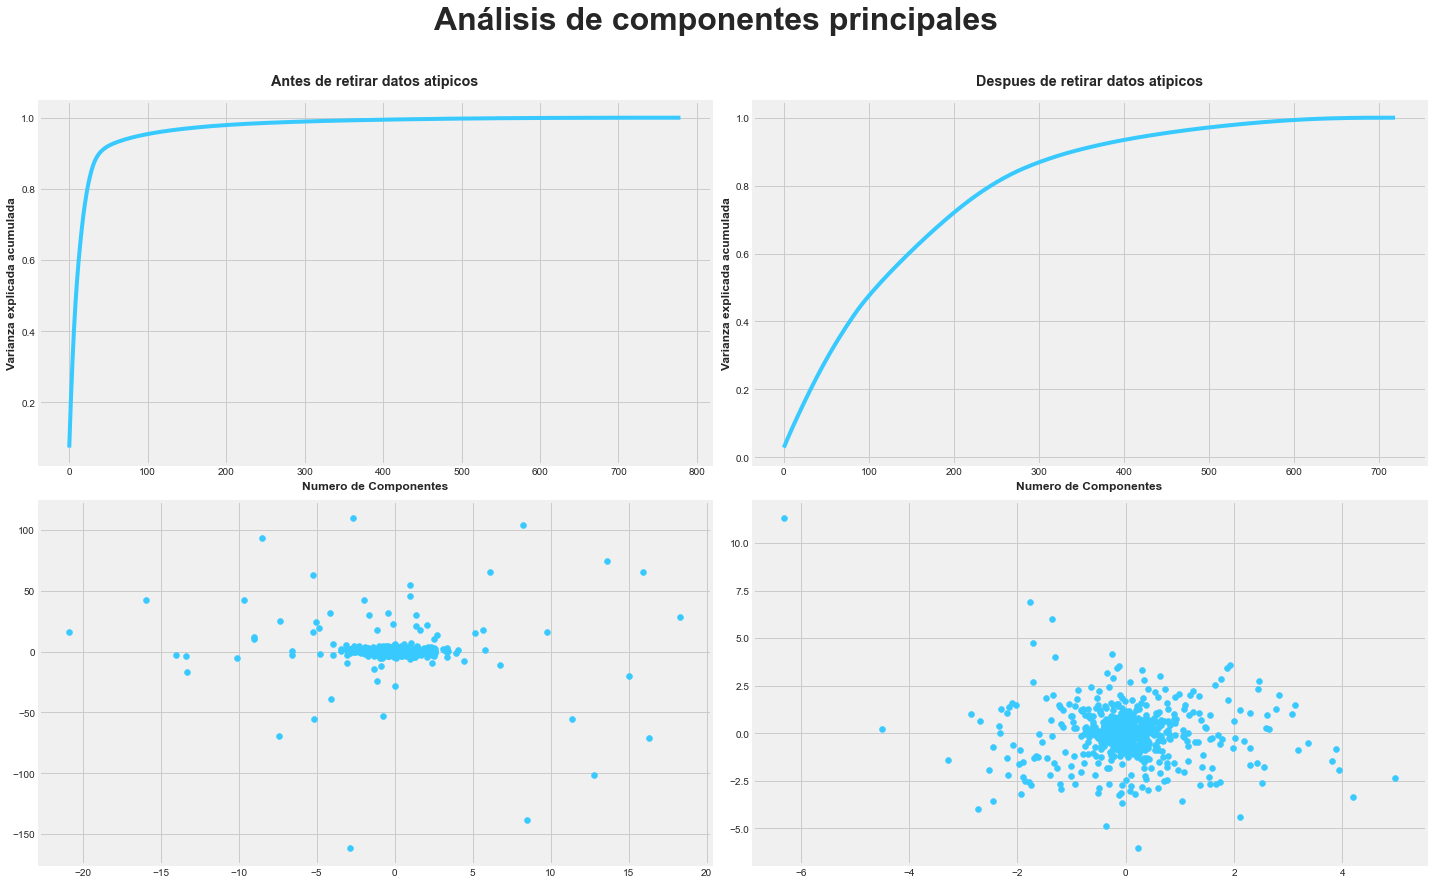

In [38]:
# Calculo de componentes principales

def plot_pca(df, col, title):
    """Plot cumulative variance and the first two components in column col of the figure."""
    pca = PCA()
    #pca.fit(StandardScaler().fit_transform(train_df.drop(columns=['id', 'target'])))
    Xt = pca.fit_transform(df.values)

    # Plot the cumulative explained variance
    plt.subplot(2, 2, col+1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), color='#38c9ff')
    plt.xlabel('Numero de Componentes')
    plt.ylabel('Varianza explicada acumulada')
    plt.title(title)

    # Scatterplot of the first two dimensions
    plt.subplot(2, 2, col+3)
    plt.scatter(Xt[0], Xt[1], color='#38c9ff')
    
temp = train_pivoted.clip(train_pivoted.quantile(0.02, axis=0).values,
                          train_pivoted.quantile(0.98, axis=0).values, 
                          axis=1)
temp.pop('sensor_12')

plt.figure(figsize=(20, 12))
plot_pca(train_pivoted, 0, 'Antes de retirar datos atipicos')
plot_pca(temp, 1, 'Despues de retirar datos atipicos')
plt.suptitle('Análisis de componentes principales',y=1.02, fontsize=32, fontweight='bold')
plt.tight_layout(h_pad=1.1)
plt.show()

# <div style="color:white;display:fill;border-radius:5px;background-color:#38c9ff;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:#FFFFFF;overflow:hidden;margin:0;font-size:110%"><b>3 |</b>  Modelado</p></div>

## <b><span style='color:#38c9ff'>3.1</span> | Ingeniería de Variables</b>

In [39]:
sensors = [col for col in train.columns if 'sensor_' in col]

train_pivoted0 = train.pivot(index=['sequence', 'subject'], columns='step', values=sensors)
display(train_pivoted0)

sensor_00                                                    \
step                    0         1         2         3         4         5    
sequence subject                                                               
0        47      -0.196291 -0.447450  0.326893  0.523184  0.272025 -1.073416   
1        66      -6.657651  1.633694  1.863215 -2.846213  0.593509  2.469861   
2        66      -1.741886  3.402628 -0.632148  0.208655 -0.800618 -2.274343   
3        542      0.264297 -1.808346  0.078825  1.037094 -0.189335 -1.302937   
4        437      0.567233 -0.823802  1.476816 -1.710201 -0.408810  0.556414   
...                    ...       ...       ...       ...       ...       ...   
25963    558     -1.441267  2.359351 -0.881762  1.299073 -0.862442 -1.428130   
25964    297      0.996909  0.415765  1.874034 -5.220247  2.927357 -0.311437   
25965    129     -0.097372 -0.860896  0.928903  0.750386  1.346986 -3.422720   
25966    170     -0.357032 -1.603555 -0.296754  0.273570  0.462133  0.244977   
25967    327     -0.313756  0.392581 -0.554096  0.070325 -0.258114  0.095054   

                                                          ...  sensor_12  \
step                    6         7         8         9   ...         50   
sequence subject                                          ...              
0        47       0.350850 -0.304482 -0.216383  0.303709  ...  -1.670077   
1        66      -1.202473 -0.829212  1.091190 -0.334621  ...  -0.338022   
2        66       2.009274 -0.563369 -0.050232  0.800618  ...  -0.172634   
3        542      1.078825  2.257342 -2.283617 -2.759660  ...   0.145354   
4        437      0.853168 -0.406491 -0.009274 -0.021638  ...   0.001705   
...                    ...       ...       ...       ...  ...        ...   
25963    558      0.125193  2.119784  0.208655  1.847759  ...   0.049020   
25964    297      0.496909  0.372488 -0.341577 -0.565688  ...  36.889173   
25965    129      0.983771  2.818393 -1.460587 -1.988408  ...   2.394714   
25966    170     -0.341577 -0.229521  0.877125 -1.197063  ...  14.010656   
25967    327      0.387172 -0.824575  0.471406 -0.037094  ...   0.909207   

                                                                         \
step                     51         52         53         54         55   
sequence subject                                                          
0        47       -5.306479   3.621057   4.965047  -3.615090   0.791134   
1        66        0.234868   0.030691   0.037511  -0.120205   0.056692   
2        66        0.091645  -0.028986  -0.202472   0.332481  -0.013214   
3        542      -0.045610  -0.098039  -0.049446   0.055840  -0.022165   
4        437      -0.050725  -0.025149   0.106138  -0.098465  -0.040068   
...                     ...        ...        ...        ...        ...   
25963    558      -0.089940   0.059250  -0.013640  -0.083973   0.026002   
25964    297      21.105286  -4.421142  16.871697  -4.326939 -13.625320   
25965    129      -0.677323   1.435209  -0.645780  -0.449275   0.271952   
25966    170      48.826939  25.958227  -7.077153 -12.375533   9.170077   
25967    327      -0.830776  -1.007246   1.064365   0.639812  -0.914749   

                                                             
step                    56         57         58         59  
sequence subject                                             
0        47       5.887042  -7.211424 -26.738704 -50.658994  
1        66       0.062234  -0.013640   0.098039  -0.115090  
2        66       0.245524  -0.091219  -0.306905   0.046036  
3        542      0.054135  -0.185422   0.311168  -0.166240  
4        437      0.135976   0.121910  -0.059676  -0.087809  
...                    ...        ...        ...        ...  
25963    558      0.036232  -0.042199   0.028986  -0.015772  
25964    297      9.957374 -13.389173 -17.123615   9.219523  
25965    129     -0.262575   0.713129  -1.378517   1.802217  
25966    170      6.789855 -15.28729

In [41]:
# Feature engineering
def engineer(df):
    new_df = pd.DataFrame([], index=df.index)
    for sensor in sensors:
        new_df[sensor + '_mean'] = df[sensor].mean(axis=1)
        new_df[sensor + '_std'] = df[sensor].std(axis=1)
        new_df[sensor + '_iqr'] = scipy.stats.iqr(df[sensor], axis=1)
        new_df[sensor + '_sm'] = np.nan_to_num(new_df[sensor + '_std'] / 
                                               new_df[sensor + '_mean'].abs()).clip(-1e30, 1e30)
        new_df[sensor + '_kurtosis'] = scipy.stats.kurtosis(df[sensor], axis=1)
    new_df['sensor_02_up'] = (df.sensor_02.diff(axis=1) > 0).sum(axis=1)
    new_df['sensor_02_down'] = (df.sensor_02.diff(axis=1) < 0).sum(axis=1)
    new_df['sensor_02_upsum'] = df.sensor_02.diff(axis=1).clip(0, None).sum(axis=1)
    new_df['sensor_02_downsum'] = df.sensor_02.diff(axis=1) .clip(None, 0).sum(axis=1)
    new_df['sensor_02_upmax'] = df.sensor_02.diff(axis=1).max(axis=1)
    new_df['sensor_02_downmax'] = df.sensor_02.diff(axis=1).min(axis=1)
    new_df['sensor_02_upmean'] = np.nan_to_num(new_df['sensor_02_upsum'] / new_df['sensor_02_up'], posinf=40)
    new_df['sensor_02_downmean'] = np.nan_to_num(new_df['sensor_02_downsum'] / new_df['sensor_02_down'], neginf=-40)
    return new_df

train_pivoted = engineer(train_pivoted0)

train_shuffled = train_pivoted.sample(frac=1.0, random_state=1)
labels_shuffled = train_labels.reindex(train_shuffled.index.get_level_values('sequence'))
labels_shuffled = labels_shuffled[['state']].merge(train[['sequence', 'subject']].groupby('sequence').min(),
                                                   how='left', on='sequence')
labels_shuffled = labels_shuffled.merge(labels_shuffled.groupby('subject').size().rename('sequence_count'),
                                        how='left', on='subject')
train_shuffled['sequence_count_of_subject'] = labels_shuffled['sequence_count'].values

selected_columns = train_shuffled.columns
print('Tenemos',len(selected_columns),'nuevas variables')
#train_shuffled.columns

Tenemos  74 nuevas columnas


Graficando las nuevas columnas vs la variable objetivo (estado del sensor)

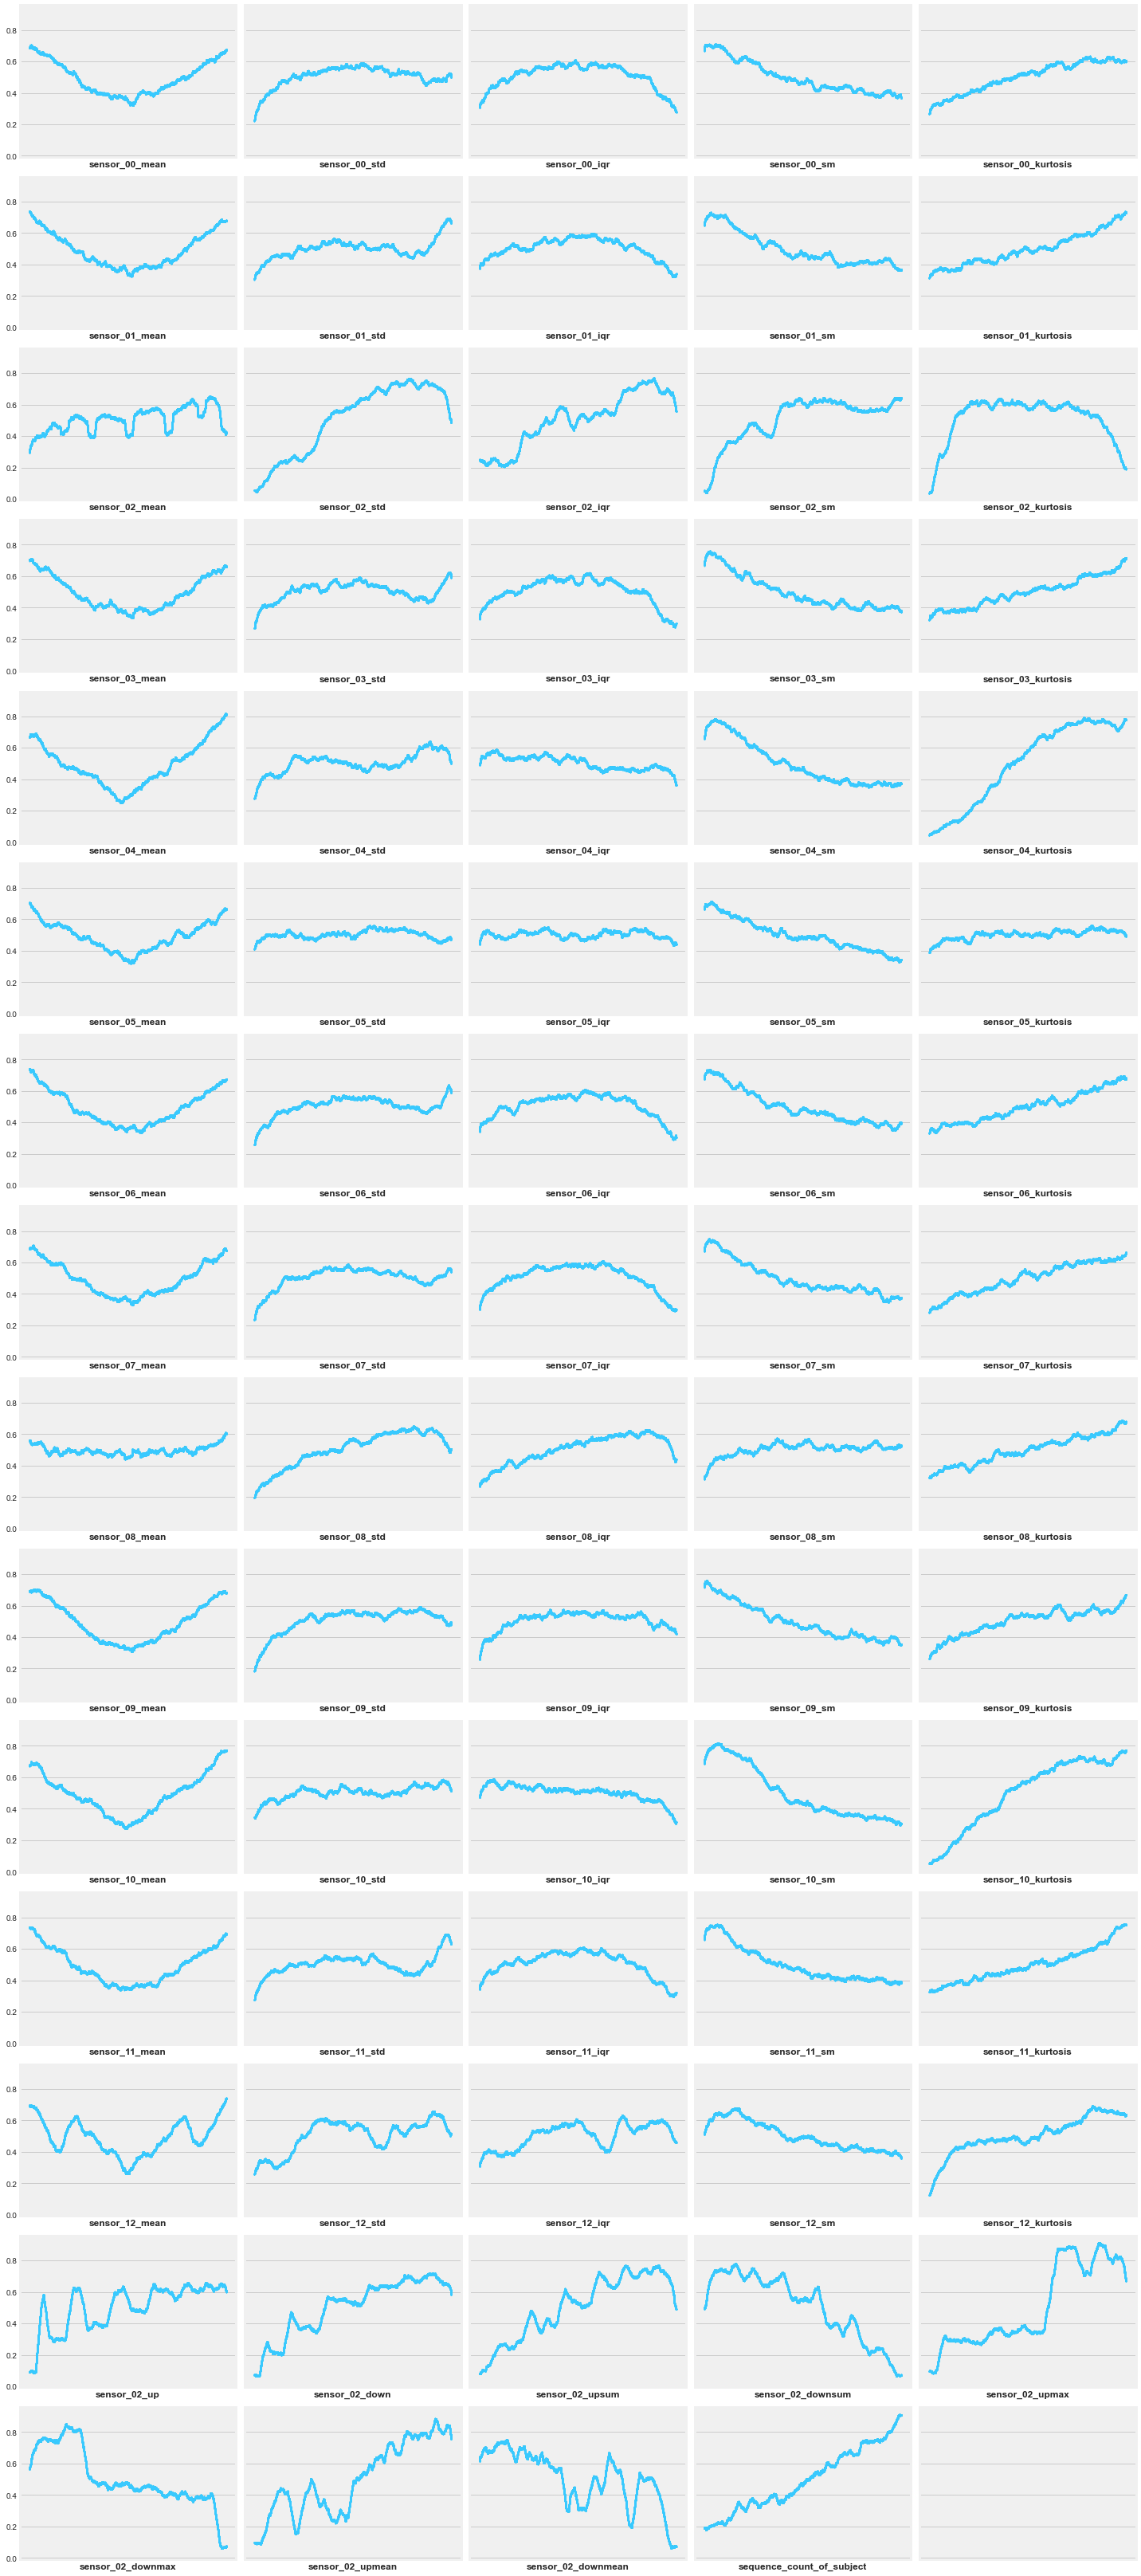

In [42]:
# Plot dependence between every feature and the target
ncols = len(train_shuffled.columns) // 13
plt.subplots(15, ncols, sharey=True, sharex=True, figsize=(20, 45))
for i, col in enumerate(train_shuffled.columns):
    temp = pd.DataFrame({col: train_shuffled[col].values,
                         'state': labels_shuffled.state.values})
    temp = temp.sort_values(col)
    temp.reset_index(inplace=True)
    plt.subplot(15, ncols, i+1)
    plt.scatter(temp.index, temp.state.rolling(1000).mean(), s=2,color='#38c9ff')
    plt.xlabel(col)
    plt.xticks([])
plt.show()

## <b><span style='color:#38c9ff'>3.2</span> | Seleccion de Variables</b>

In [49]:
# Eliminando las nuevas variables poco utiles
dropped_features = ['sensor_05_kurtosis', 'sensor_08_mean',
                    'sensor_05_std', 'sensor_06_kurtosis',
                    'sensor_06_std', 'sensor_03_std',
                    'sensor_02_kurtosis', 'sensor_03_kurtosis',
                    'sensor_09_kurtosis', 'sensor_03_mean',
                    'sensor_00_mean', 'sensor_02_iqr',
                    'sensor_05_mean', 'sensor_06_mean',
                    'sensor_07_std', 'sensor_10_iqr',
                    'sensor_11_iqr', 'sensor_12_iqr',
                    'sensor_09_mean', 'sensor_02_sm',
                    'sensor_03_sm', 'sensor_05_iqr', 
                    'sensor_06_sm', 'sensor_09_iqr', 
                    'sensor_07_iqr', 'sensor_10_mean']
selected_columns = [f for f in selected_columns if f not in dropped_features]
print('Nos quedan',len(selected_columns),'variables')

Nos quedan 48 variables


Added feature: sensor_04_kurtosis             0.787
Added feature: sensor_02_upmax                0.861
Added feature: sequence_count_of_subject      0.899
Added feature: sensor_02_downmax              0.918
Added feature: sensor_02_std                  0.923
Added feature: sensor_10_sm                   0.927
Added feature: sensor_00_std                  0.929
Added feature: sensor_05_sm                   0.931
Added feature: sensor_11_sm                   0.933
Added feature: sensor_10_kurtosis             0.934
Added feature: sensor_02_downsum              0.936
Added feature: sensor_12_sm                   0.937
Added feature: sensor_12_std                  0.938
Added feature: sensor_04_iqr                  0.938
Added feature: sensor_04_mean                 0.939
Added feature: sensor_00_kurtosis             0.940
Added feature: sensor_08_std                  0.941
Added feature: sensor_02_upmean               0.941
Added feature: sensor_09_sm                   0.942
Added featur

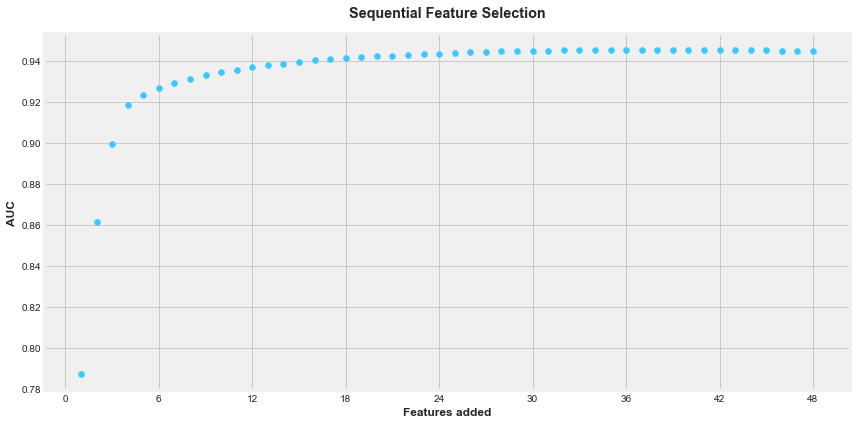

['sensor_00_std' 'sensor_00_iqr' 'sensor_00_sm' 'sensor_00_kurtosis'
 'sensor_01_mean' 'sensor_01_std' 'sensor_01_iqr' 'sensor_01_sm'
 'sensor_01_kurtosis' 'sensor_02_mean' 'sensor_02_std' 'sensor_03_iqr'
 'sensor_04_mean' 'sensor_04_std' 'sensor_04_iqr' 'sensor_04_sm'
 'sensor_04_kurtosis' 'sensor_05_sm' 'sensor_06_iqr' 'sensor_07_mean'
 'sensor_07_sm' 'sensor_07_kurtosis' 'sensor_08_std' 'sensor_08_iqr'
 'sensor_08_sm' 'sensor_08_kurtosis' 'sensor_09_std' 'sensor_09_sm'
 'sensor_10_std' 'sensor_10_sm' 'sensor_10_kurtosis' 'sensor_11_mean'
 'sensor_11_std' 'sensor_11_sm' 'sensor_11_kurtosis' 'sensor_12_mean'
 'sensor_12_std' 'sensor_12_sm' 'sensor_12_kurtosis' 'sensor_02_up'
 'sensor_02_down' 'sensor_02_upsum' 'sensor_02_downsum' 'sensor_02_upmax'
 'sensor_02_downmax' 'sensor_02_upmean' 'sensor_02_downmean'
 'sequence_count_of_subject']


In [44]:
# Seleccion secuencial de variables 

estimator = HistGradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=25,
                                       max_iter=1000, min_samples_leaf=500,
                                       l2_regularization=1,
                                       max_bins=255,
                                       random_state=4, verbose=0)

X, y = train_shuffled[selected_columns], labels_shuffled.state
n_iterations, backward = 48, False

if n_iterations != 0:
    n_features = X.shape[1]
    current_mask = np.zeros(shape=n_features, dtype=bool)
    history = []
    for _ in range(n_iterations):
        candidate_feature_indices = np.flatnonzero(~current_mask)
        scores = {}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            X_new = X.values[:, ~candidate_mask if backward else candidate_mask]
            scores[feature_idx] = cross_val_score(
                estimator,
                X_new,
                y,
                cv=GroupKFold(n_splits=5),
                groups=train_shuffled.index.get_level_values('subject'),
                scoring='roc_auc',
                n_jobs=-1,
            ).mean()
            #print(f"{str(X.columns[feature_idx]):30} {scores[feature_idx]:.3f}")
        new_feature_idx = max(scores, key=lambda feature_idx: scores[feature_idx])
        current_mask[new_feature_idx] = True
        history.append(scores[new_feature_idx])
        new = 'Eliminada' if backward else 'Agregada'
        print(f'{new} Variable: {str(X.columns[new_feature_idx]):30}'
              f' {scores[new_feature_idx]:.3f}')

    print()
    plt.figure(figsize=(12, 6))
    plt.scatter(np.arange(len(history)) + (0 if backward else 1), history, color='#38c9ff')
    plt.ylabel('AUC')
    plt.xlabel('Variables Eliminadas' if backward else 'Variables Agregadas')
    plt.title('Seleccion Secuencial de Variables')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

    if backward:
        current_mask = ~current_mask
    selected_columns = np.array(selected_columns)[current_mask]
    print(selected_columns)

## <b><span style='color:#38c9ff'>3.3</span> | Validación del Modelo (Cross Validation)</b>

In [50]:
%%time
# Cross-validation of the classifier

print(f"{len(selected_columns)} features")
score_list = []
kf = GroupKFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_shuffled, groups=train_shuffled.index.get_level_values('subject'))):
    X_tr = train_shuffled.iloc[idx_tr][selected_columns]
    X_va = train_shuffled.iloc[idx_va][selected_columns]
    y_tr = labels_shuffled.iloc[idx_tr].state
    y_va = labels_shuffled.iloc[idx_va].state

    model = HistGradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=25,
                                           max_iter=1000, min_samples_leaf=500,
                                           l2_regularization=1,
                                           validation_fraction=0.05,
                                           max_bins=63,
                                           random_state=3, verbose=0)
#     model = XGBClassifier(n_estimators=500, n_jobs=-1,
#                           eval_metric=['logloss'],
#                           #max_depth=10,
#                           colsample_bytree=0.8,
#                           #gamma=1.4,
#                           reg_alpha=6, reg_lambda=1.5,
#                           tree_method='hist',
#                           learning_rate=0.03,
#                           verbosity=1,
#                           use_label_encoder=False, random_state=3)

    if True or type(model) != XGBClassifier:
        model.fit(X_tr.values, y_tr)
    else:
        model.fit(X_tr.values, y_tr, eval_set = [(X_va.values, y_va)], 
                  eval_metric = ['auc'], early_stopping_rounds=30, verbose=10)
    try:
        y_va_pred = model.decision_function(X_va.values) # HistGradientBoostingClassifier
    except AttributeError:
        try:
            y_va_pred = model.predict_proba(X_va.values)[:,1] # XGBClassifier
        except AttributeError:
            y_va_pred = model.predict(X_va.values) # XGBRegressor
    score = roc_auc_score(y_va, y_va_pred)
    try:
        print(f"Fold {fold}: n_iter ={model.n_iter_:5d}    AUC = {score:.3f}")
    except AttributeError:
        print(f"Fold {fold}:                  AUC = {score:.3f}")
    score_list.append(score)
    
print(f"OOF AUC:                       {np.mean(score_list):.3f}") # 0.944

48 features
Fold 0: n_iter =  213    AUC = 0.942
Fold 1: n_iter =  280    AUC = 0.943
Fold 2: n_iter =  321    AUC = 0.949
Fold 3: n_iter =  292    AUC = 0.946
Fold 4: n_iter =  406    AUC = 0.944
OOF AUC:                       0.945
CPU times: total: 1min 50s
Wall time: 8.65 s


## <b><span style='color:#38c9ff'>3.4</span> | Curva ROC</b>

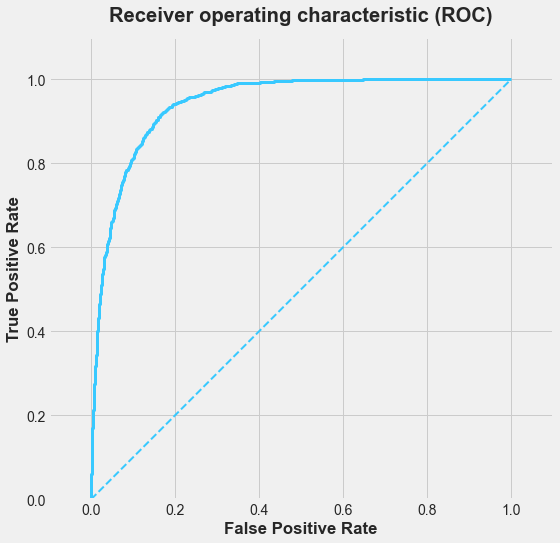

In [60]:
# Plot the roc curve for the last fold
def plot_roc_curve(y_va, y_va_pred):
    plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(y_va, y_va_pred)
    plt.plot(fpr, tpr, lw=3,color='#38c9ff')
    plt.plot([0, 1], [0, 1], color="#38c9ff", lw=2, linestyle="--")
    plt.gca().set_aspect('equal')
    plt.xlim([-0.1, 1.1])
    plt.ylim([0.0, 1.1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic (ROC)")
    plt.show()

plot_roc_curve(y_va, y_va_pred)

## <b><span style='color:#38c9ff'>3.5</span> | Predicciones con el Dataset de Testeo</b>

In [61]:
# Feature engineering for test
test_pivoted0 = test.pivot(index=['sequence', 'subject'], columns='step', values=sensors)
test_pivoted = engineer(test_pivoted0)
sequence_count = test_pivoted.index.to_frame(index=False).groupby('subject').size().rename('sequence_count_of_subject')
#display(test_pivoted.head(2))
submission = pd.DataFrame({'sequence': test_pivoted.index.get_level_values('sequence')})
test_pivoted = test_pivoted.merge(sequence_count, how='left', on='subject')
test_pivoted.head(2)

,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_sm,sensor_00_kurtosis,sensor_01_mean,sensor_01_std,sensor_01_iqr,sensor_01_sm,sensor_01_kurtosis,...,sensor_12_kurtosis,sensor_02_up,sensor_02_down,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean,sequence_count_of_subject
subject,,,,,,,,,,,,,,,,,,,,,
684,-0.002602,1.091741,1.078632,419.617542,6.400715,-0.036432,4.499484,0.990284,123.503376,13.679216,...,-0.293747,4,8,0.666667,-1.332820,0.176667,-0.176667,0.166667,-0.166602,70
935,0.028516,1.450040,0.844281,50.849655,6.634402,0.002276,0.775379,1.079832,340.689694,0.125149,...,-1.044935,5,9,1.226502,-1.560349,0.559836,-0.228685,0.245300,-0.173372,59


In [62]:
# Retrain, predict and write submission
print(f"{len(selected_columns)} Variables")

pred_list = []
for seed in range(100):
    X_tr = train_shuffled[selected_columns]
    y_tr = labels_shuffled.state

    model = HistGradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=25,
                                           max_iter=1000, min_samples_leaf=500,
                                           validation_fraction=0.05,
                                           l2_regularization=1,
                                           max_bins=63,
                                           random_state=seed, verbose=0)
    model.fit(X_tr.values, y_tr)
    pred_list.append(scipy.stats.rankdata(model.decision_function(test_pivoted[selected_columns].values)))
    print(f"{seed:2}", pred_list[-1])
print()
submission['state'] = sum(pred_list) / len(pred_list)
submission.to_csv('submission.csv', index=False)
submission

48 features
 0 [ 8571. 11650.   412. ...  5840.   955.  2553.]
 1 [ 8823. 11782.   999. ...  6063.   797.  2893.]
 2 [ 9157. 11859.   756. ...  5886.  1251.  2681.]
 3 [ 8049. 11549.   633. ...  6104.   843.  2819.]
 4 [ 8407. 11819.   817. ...  5804.  1467.  2968.]
 5 [ 8296. 11717.   768. ...  5953.  1283.  2943.]
 6 [ 8401. 11796.   676. ...  5780.  1258.  3048.]
 7 [ 8132. 11701.   827. ...  6391.  1181.  2453.]
 8 [ 8291. 11642.   730. ...  5783.  1106.  2940.]
 9 [ 8274. 11824.   747. ...  5833.  1185.  2803.]
10 [ 8225. 11618.   699. ...  5901.  1062.  2557.]
11 [ 9055. 11444.   907. ...  5744.  1244.  3306.]
12 [ 8549. 11985.   394. ...  6428.   885.  2984.]
13 [ 8399. 11830.   770. ...  5360.  1059.  2827.]
14 [ 8162. 11682.   811. ...  6170.   970.  3378.]
15 [ 7993. 11607.  1002. ...  6005.   812.  2678.]
16 [ 8899. 11613.   667. ...  6682.  1078.  2362.]
17 [ 8383. 11962.   500. ...  5783.  1298.  2678.]
18 [ 8060. 11824.   543. ...  6418.  1018.  2791.]
19 [ 8503. 11934.  

,sequence,state
0,25968,8499.27
1,25969,11734.88
2,25970,770.63
3,25971,7405.85
4,25972,6505.02
...,...,...
12213,38181,9150.44
12214,38182,8400.96
12215,38183,5955.93
12216,38184,1167.29


# <div style="color:white;display:fill;border-radius:5px;background-color:#38c9ff;letter-spacing:0.5px;overflow:hidden"><p style="padding:20px;color:#FFFFFF;overflow:hidden;margin:0;font-size:110%"><b>4 |</b>  Conclusiones</p></div>

## <b><span style='color:#38c9ff'>4.1</span> | Referencias</b>